In [20]:
sys.path.append("..")
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
colors = sns.color_palette("Set2")

In [2]:
def get_paths(relative_dir = "results/latest/"):
    paths = os.listdir("../" + relative_dir)
    rel_paths = []
    for i in range(len(paths)):
        if not (paths[i] == '.DS_Store' or paths[i] == 'archive'):
            rel_paths.append(relative_dir + paths[i])
    return rel_paths

## Plot vaccinated distribution for all results

Read results

In [3]:
def find_policy_name(path):
    string = path.split("_")[2]
    if string == 'susceptible':
        return "Population-Based"
    if string == 'infection':
        return "Infection-Based"
    if string == 'random':
        return "Random"
    if string == 'oldest':
        return "Age-Based"
    if string == 'contact':
        return "Contact-Based"
    if string == 'fhi':
        return "NIPH"

In [19]:
paths = get_paths()
results = {}
for relative_path in paths:
    key = find_policy_name(relative_path)
    results[key] = utils.read_csv(relative_path=relative_path)

fhi policy
random 2021
susceptible based
infection based
oldest first
contact based
fhi
Reading results ..
100%|██████████| 500/500 [00:07<00:00, 69.79it/s]
random
Reading results ..
100%|██████████| 500/500 [00:06<00:00, 74.07it/s]
susceptible
Reading results ..
100%|██████████| 500/500 [00:12<00:00, 41.63it/s]
infection
Reading results ..
100%|██████████| 500/500 [00:11<00:00, 43.64it/s]
oldest
Reading results ..
100%|██████████| 500/500 [00:09<00:00, 51.02it/s]
contact
Reading results ..
100%|██████████| 500/500 [00:06<00:00, 73.05it/s]


In [12]:
results.keys()

dict_keys(['results/latest/500_simulations_fhi_policy_2021_06_04_01_19_24', 'results/latest/500_simulations_random_2021_06_04_01_53_19', 'results/latest/500_simulations_susceptible_based_2021_06_04_01_17_03', 'results/latest/500_simulations_infection_based_2021_06_04_01_18_10', 'results/latest/500_simulations_oldest_first_2021_06_04_01_18_05', 'results/latest/500_simulations_contact_based_2021_06_04_01_21_27'])

fhi policy
random 2021
susceptible based
infection based
oldest first
contact based


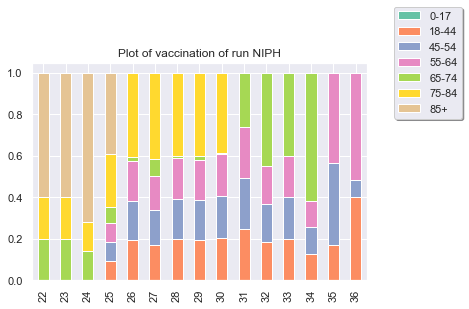

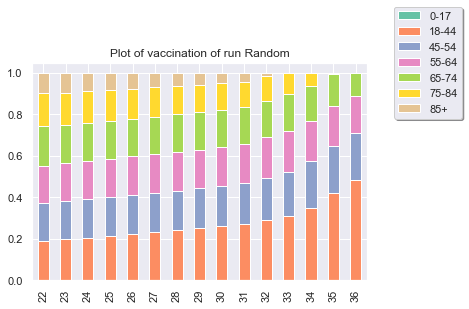

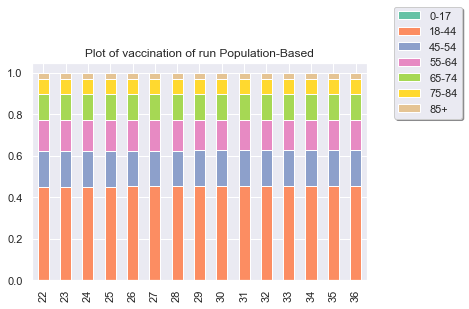

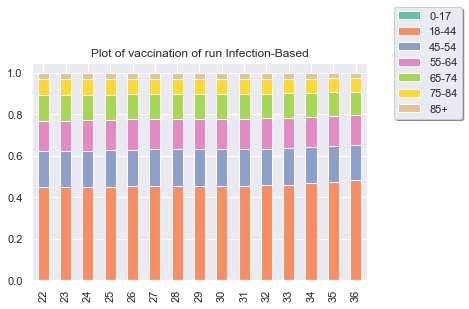

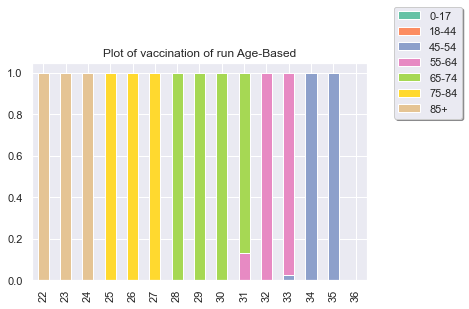

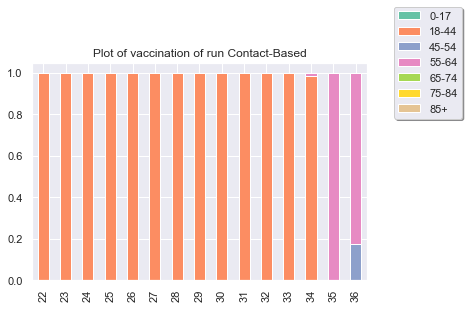

In [22]:
paths = get_paths()
keys = list(results.keys())
for i in range(len(keys)):
    age_labels = results[keys[i]][0]
    vaccinated_age_groups = results[keys[i]][-2]
    vaccinated_age_groups = np.diff(vaccinated_age_groups, axis=1)
    vaccinated_mean = vaccinated_age_groups.mean(axis=0)
    week_cut = np.where(vaccinated_mean > 0)[0][0]
    norm = np.where(np.int64(vaccinated_mean.sum(axis=1, keepdims=True))==0, 1, vaccinated_mean.sum(axis=1, keepdims=True))
    vaccinated_mean[week_cut:].sum(axis=1)
    vaccinated_proportions = np.divide(vaccinated_mean, norm)
    vaccinated_proportions[week_cut:].sum(axis=1)
    vaccinated_cumsum = vaccinated_mean.cumsum(axis=1)
    weeks = np.arange(vaccinated_proportions.shape[0])
    df = pd.DataFrame(columns = age_labels, data=vaccinated_proportions[week_cut:], index=weeks[week_cut:])
    sns.set()
    df.plot(kind='bar', stacked=True, color=colors)
    plt.title(f"Plot of vaccination of {keys[i]}")
    plt.legend(loc='right', bbox_to_anchor=(1.3, 1), ncol=1, fancybox=True, shadow=True)
    plt.show()

## Analysis of simulations needed

In [54]:
nr_sim = results[list(results.keys())[0]][4].shape[0]
objective_values = {}
for keys in results.keys():
    objective_values[keys] = np.zeros((nr_sim,5)) #axis 1: index 0: deaths, 1: infected, 2: yll, 3: vaccinated, 4: weighted


In [55]:
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)

for key in list(results.keys()):
    print("Finding objective values for ", key)
    result = results[key]
    age_labels = result[0]
    
    new_deaths_age_groups = result[-3]
    cumulative_deaths = new_deaths_age_groups.cumsum(axis=1)
    cum_deaths = np.zeros((cumulative_deaths.shape[0], cumulative_deaths.shape[2]))
    yll = np.zeros((cumulative_deaths.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        cum_deaths[i] = cumulative_deaths[i,-1,:]
        yll[i] = utils.calculate_yll(utils.get_expected_yll(config.age_bins, age_labels),  cum_deaths[i]) 
    deaths = np.sum(cum_deaths, axis=1)

    new_infected_age_groups = result[-4]
    cumulative_infected = new_infected_age_groups.cumsum(axis=1)
    infected = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_infected.shape[0]):
        infected[i] = np.sum(cumulative_infected[i,-1,:])

    vaccinated_age_groups = result[-2]
    vaccinated = np.zeros((vaccinated_age_groups.shape[0]))
    for i in range(vaccinated_age_groups.shape[0]):
        vaccinated[i] = np.sum(vaccinated_age_groups[i,-1,:])

    weighted = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        weighted[i] = 0.01*infected[i] + deaths[i]
        

    objective_values[key][:,0] = deaths
    objective_values[key][:,1] = infected
    objective_values[key][:,2] = yll
    objective_values[key][:,3] = vaccinated
    objective_values[key][:,4] = weighted

Finding objective values for  NIPH
Finding objective values for  Random
Finding objective values for  Population-Based
Finding objective values for  Infection-Based
Finding objective values for  Age-Based
Finding objective values for  Contact-Based


In [85]:
colors = sns.color_palette("Set2")
def density_plot(values, key, color):
    # Draw the density plot
    plot = sns.distplot(values, hist=False, kde=True,
                 kde_kws={'linewidth': 1.5},
                 label=key, color=color)
    plot.set(yticklabels=[])
    plot.set(xlabel=None, ylabel=None)

Deaths

Infected

YLL

Weighted



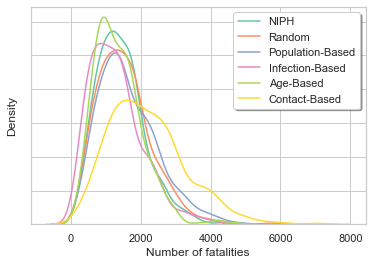

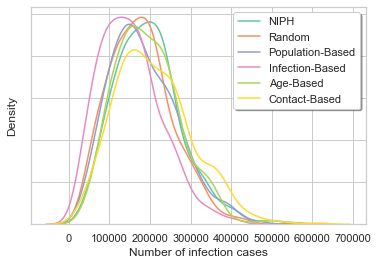

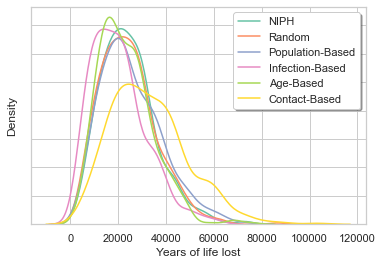

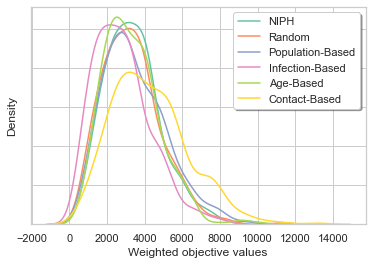

In [91]:
keys = list(results.keys())
print("Deaths")
print()
plt.figure()
for n in range(len(keys)):
    density_plot(objective_values[keys[n]][:,0], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=True)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig("../plots/computational_study/fatalities_distributions.png")

print("Infected")
print()
plt.figure()
for n in range(len(keys)): 
    density_plot(objective_values[keys[n]][:,1], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=True)
plt.xlabel('Number of infection cases')
plt.ylabel("Density")
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig("../plots/computational_study/infected_distributions.png")


print("YLL")
print()
plt.figure()
    #if i==0: j, k = 0,0
    #elif i==1: j, k = 0,1
    #elif i==2: j, k = 1,0
    #elif i==3: j, k = 1,1
for n in range(len(keys)): 
    density_plot(objective_values[keys[n]][:,2], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=True)
plt.xlabel('Years of life lost')
plt.ylabel("Density")
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig("../plots/computational_study/yll_distributions.png")

print("Weighted")
print()
plt.figure()
for n in range(len(keys)): 
    density_plot(objective_values[keys[n]][:,4], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=True)
plt.xlabel('Weighted objective values')
plt.ylabel("Density")
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig("../plots/computational_study/weighted_distributions.png")



## T-test of observations

In [58]:
def t_test(first, second):
        """ Performs one-sided t-test to check to variables for significant difference

        Args:
            first (Individual): presumed best individual
            second (Individual): presumed worse individual
            significance (float, optional): level of significance to test against. Defaults to 0.1.

        Returns:
            bool: True if significance is achieved
        """
        if not (first==second).all():
            z = first - second
            return scipy.stats.ttest_ind(z, np.zeros(len(first)), alternative="less").pvalue
        return 1

In [59]:
dead = dict(map(lambda x: (x[0], np.array(x[1])[:,0]), objective_values.items()))
infected = dict(map(lambda x: (x[0], np.array(x[1])[:,1]), objective_values.items()))
yll = dict(map(lambda x: (x[0], np.array(x[1])[:,2]), objective_values.items()))
vaccinated = dict(map(lambda x: (x[0], np.array(x[1])[:,3]), objective_values.items()))
weighted = dict(map(lambda x: (x[0], np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1]), objective_values.items()))

mean_dead = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0])), objective_values.items()))
mean_infected = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,1])), objective_values.items()))
mean_yll = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,2])), objective_values.items()))
mean_vaccinated = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,3])), objective_values.items()))
mean_weighted = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1])), objective_values.items()))

sorted_dead = dict(sorted(mean_dead.items(), key=lambda x: x[1]))
sorted_infected = dict(sorted(mean_infected.items(), key=lambda x: x[1]))
sorted_yll = dict(sorted(mean_yll.items(), key=lambda x: x[1]))
sorted_vaccinated = dict(sorted(mean_vaccinated.items(), key=lambda x: x[1]))
sorted_weighted = dict(sorted(mean_weighted.items(), key=lambda x: x[1]))
 
std_dead = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0])), objective_values.items()))
std_infected = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,1])), objective_values.items()))
std_yll = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,2])), objective_values.items()))
std_vaccinated = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,3])), objective_values.items()))
std_weighted = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1])), objective_values.items()))


In [60]:
#sns.distplot(objective_values['results/500_simulations_oldest_first_2021_06_02_12_35_16'][:,0])

[]
[151952.95971109986, 194407.12151672482, 195378.94492677427, 177880.4981548016, 185008.2272313756, 209603.1796045095]
[76149.03761624897, 80892.72614064078, 81249.90524751657, 79036.54937174422, 83254.65078291456, 94207.29926808696]


Text(0, 0.5, 'Years of life lost')

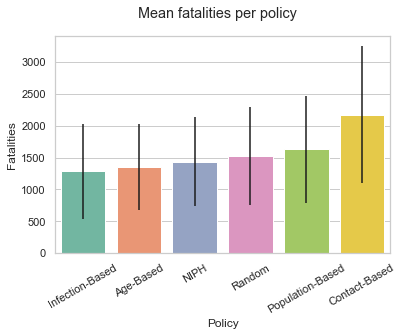

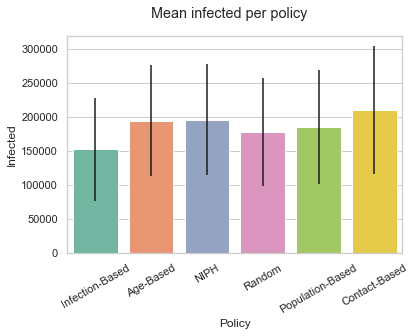

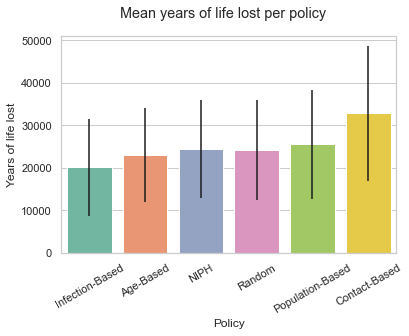

In [61]:
sns.set_theme(style="whitegrid")
keys=list(sorted_dead.keys())
plt.figure()
y=[]
yerr=[]
for key in keys:
    y.append(sorted_dead[key])
    yerr.append(std_dead[key])
sns.barplot(x=keys, y=y, yerr=yerr, palette=colors)
plt.suptitle("Mean fatalities per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Fatalities")

plt.figure()
y=[]
yerr=[]
for key in keys:
    y.append(sorted_infected[key])
    yerr.append(std_infected[key])
print(x)
print(y)
print(yerr)
sns.barplot(x=keys, y=y, yerr=yerr, palette=colors)

plt.suptitle("Mean infected per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Infected")

plt.figure()
y=[]
yerr=[]
for key in keys:
    y.append(sorted_yll[key])
    yerr.append(std_yll[key])
sns.barplot(x=keys, y=y, yerr=yerr, palette=colors)

plt.suptitle("Mean years of life lost per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Years of life lost")

In [67]:
print()
print("Dead")
for key in mean_dead:
    print(f"{key:>20} {mean_dead[key]:>8,.0f} {std_dead[key]:>8,.0f}")
print()
print()
print("Infected")
for key in mean_infected:
    print(f"{key:>20} {mean_infected[key]:>8,.0f} {std_infected[key]:>8,.0f}")
print()
print()
print("YLL")
for key in mean_yll:
    print(f"{key:>20} {mean_yll[key]:>8,.0f} {std_yll[key]:>8,.0f}")
print()
print()
print("Vaccinated")
for key in mean_vaccinated:
    print(f"{key:>20} {mean_vaccinated[key]:>8,.0f} {std_vaccinated[key]:>8,.0f}")

print()
print()
print("Weighted")
for key in mean_weighted:
    print(f"{key:>20} {mean_weighted[key]:>8,.0f} {std_weighted[key]:>8,.0f}")


Dead
                NIPH    1,437      697
              Random    1,523      765
    Population-Based    1,632      842
     Infection-Based    1,284      745
           Age-Based    1,351      674
       Contact-Based    2,174    1,080


Infected
                NIPH  195,379   81,250
              Random  177,880   79,037
    Population-Based  185,008   83,255
     Infection-Based  151,953   76,149
           Age-Based  194,407   80,893
       Contact-Based  209,603   94,207


YLL
                NIPH   24,411   11,530
              Random   24,164   11,798
    Population-Based   25,532   12,826
     Infection-Based   20,160   11,431
           Age-Based   23,079   11,118
       Contact-Based   32,805   15,869


Vaccinated
                NIPH 2,445,448   40,608
              Random 1,773,825   27,616
    Population-Based 2,441,764        0
     Infection-Based 2,053,440  211,433
           Age-Based 1,924,081  221,287
       Contact-Based 2,229,631  175,679


Weighted
           

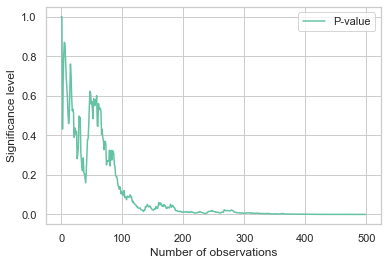

In [105]:
objective_value_best = objective_values[list(sorted_dead.keys())[0]][:,0]
objective_value_second_best = objective_values[list(sorted_dead.keys())[1]][:,0]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color=colors[0])
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/fatalities_significance.png")

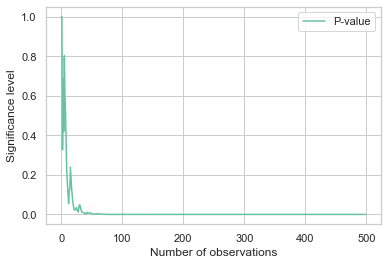

In [97]:
objective_value_best = objective_values[list(sorted_infected.keys())[0]][:,1]
objective_value_second_best = objective_values[list(sorted_infected.keys())[1]][:,1]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color=colors[0])
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/infected_significance.png")

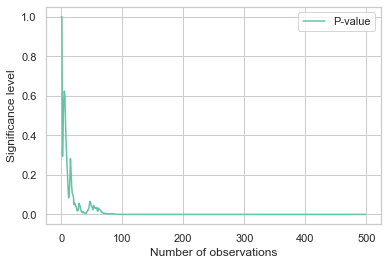

In [98]:
objective_value_best = objective_values[list(sorted_yll.keys())[0]][:,2]
objective_value_second_best = objective_values[list(sorted_yll.keys())[1]][:,2]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color=colors[0])
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/yll_significance.png")

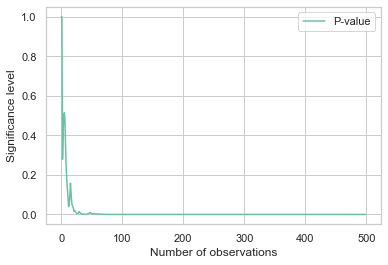

In [146]:
objective_value_best = objective_values[list(sorted_yll.keys())[0]][:,4]
objective_value_second_best = objective_values[list(sorted_yll.keys())[1]][:,4]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color=colors[0])
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/weighted_significance.png")

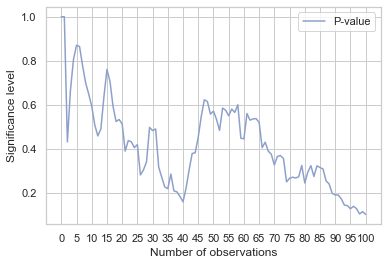

In [170]:
objective_value_best = objective_values[list(sorted_dead.keys())[0]][:,0]
objective_value_second_best = objective_values[list(sorted_dead.keys())[1]][:,0]

p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations[:101], p_values[:101], label="P-value", color=colors[2])
plt.xticks(observations[0:101:5])
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/fatalities_significance_narrowed.png")

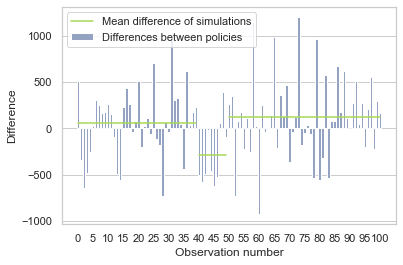

In [175]:

observations = np.arange(len(objective_value_best))
diffs = np.arange(len(objective_value_best))
for i in range( len(objective_value_best)-1):
   diffs[i] = objective_value_second_best[i] - objective_value_best[i]

diff1 = np.mean(diffs[:])
diff2 = np.mean(diffs[:50])
diff3 = np.mean(diffs[40:50])
diff4 = np.mean(diffs[50:100])
diff5 = np.mean(diffs[50:])

sns.set()
sns.set_style("whitegrid")
sns.barplot(observations[:101], diffs[:101], label = "Differences between policies", color=colors[2])
sns.lineplot(observations[:40], np.mean(diffs[:40]), label = "Mean difference of simulations", color=colors[4])
sns.lineplot(observations[40:50], np.mean(diffs[40:50]), color=colors[4])
sns.lineplot(observations[50:101], np.mean(diffs[50:101]), color=colors[4])
plt.xticks(observations[0:101:5])
plt.xlabel("Observation number")
plt.ylabel("Difference", labelpad=-2)
plt.set_label_coords(-0.075, 0.25)
plt.savefig("../plots/computational_study/fatalities_diffs.png")

68.478
-10.0
-285.9
116.66
77.19777777777777
(array([ 1,  2,  3,  4, 12, 13, 14, 18, 21, 24, 26, 27, 28, 30, 35, 40, 41,
       42, 43, 44, 45, 46, 49, 52, 55, 57, 60, 62, 63, 66, 70, 71, 74, 75,
       77, 78, 80, 81, 83, 95, 98]),)


In [134]:
print(diffs[:100])

[ 513 -346 -648 -481 -256   29  302  256  165  173  263  157  -98 -499
 -560  228  435  267  -35   79  513 -200   22  113  -58  702 -117 -178
 -732   70  -35 1000  304  327   51 -436  618   36  182  233 -503 -579
 -492  -22 -467 -629 -529   57  396  -91  259  348 -738   75  181 -226
  113 -260 1147   26 -932  248  -45  -12  141  989 -216  366  129  467
 -361  -36  125 1208 -181  -56   37  -58 -533  967 -555 -321  581 -535
   83   78  677  182  618  115    4  275  513   48  274 -207  208  556
 -226  293]
